In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.data_util import load_augmented_example
from src.evaluation import DAP_SAP_MAP_kde, hist_AP, plot_SAP_MAP

import tensorflow as tf

from sklearn.model_selection import train_test_split
import glob
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "6"

import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

2024-12-12 15:15:43.378826: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 15:15:44.015992: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load training and validation data

![](images/hist_pig_samples_aug_v2.png)

The model is tuned using the augmented prepared data (hatched orange/blue) and the prepared original data (blue) and is validated using the validation data (green).

In [14]:
pigs = ["P_{0:02d}_PulHyp".format(i) for i in range(1, 10)]
print(pigs)

load_path = "/data/PulHypStudie_Check_npz_v3_SNR30/"

['P_01_PulHyp', 'P_02_PulHyp', 'P_03_PulHyp', 'P_04_PulHyp', 'P_05_PulHyp', 'P_06_PulHyp', 'P_07_PulHyp', 'P_08_PulHyp', 'P_09_PulHyp']


In [15]:
X_train, y_train, clrs_pig_train = load_augmented_example(
    load_path, pigs, sample_skip=500, load_samples="upwards", shuffle=True
)

Selected 14500 from /data/PulHypStudie_Check_npz_v3_SNR30/P_01_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v3_SNR30/P_01_PulHyp/sample_014999.npz from pig P_01_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v3_SNR30/P_02_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v3_SNR30/P_02_PulHyp/sample_014999.npz from pig P_02_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v3_SNR30/P_03_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v3_SNR30/P_03_PulHyp/sample_014999.npz from pig P_03_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v3_SNR30/P_04_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v3_SNR30/P_04_PulHyp/sample_014999.npz from pig P_04_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v3_SNR30/P_05_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v3_SNR30/P_05_PulHyp/sample_014999.npz from pig P_05_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v3_SNR30/P_06_PulHyp/sample_000500.npz to /dat

In [16]:
X_valid, y_valid, clrs_pig_valid = load_augmented_example(
    load_path, pigs, sample_skip=500, load_samples="downwards", shuffle=True
)

Selected 500 from /data/PulHypStudie_Check_npz_v3_SNR30/P_01_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v3_SNR30/P_01_PulHyp/sample_000499.npz from pig P_01_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v3_SNR30/P_02_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v3_SNR30/P_02_PulHyp/sample_000499.npz from pig P_02_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v3_SNR30/P_03_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v3_SNR30/P_03_PulHyp/sample_000499.npz from pig P_03_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v3_SNR30/P_04_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v3_SNR30/P_04_PulHyp/sample_000499.npz from pig P_04_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v3_SNR30/P_05_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v3_SNR30/P_05_PulHyp/sample_000499.npz from pig P_05_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v3_SNR30/P_06_PulHyp/sample_000000.npz to /data/PulHypStud

In [17]:
print(
    X_train.shape,
    X_valid.shape,
    y_train.shape,
    y_valid.shape,
    clrs_pig_train.shape,
    clrs_pig_valid.shape,
)

(130500, 64, 1024, 1) (4500, 64, 1024, 1) (130500, 3) (4500, 3) (130500, 3) (4500, 3)


**PCA**

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(
    X_valid.reshape(X_valid.shape[0], X_valid.shape[1] * X_valid.shape[2])
)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

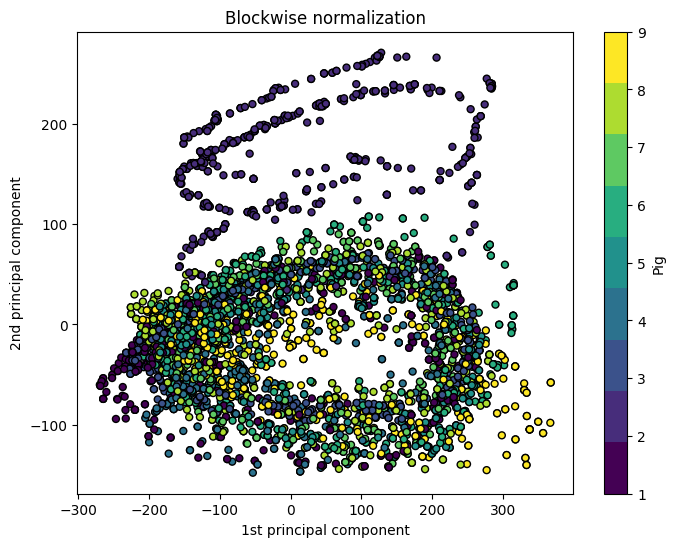

In [19]:
pigs_int = [int(c[0][4:6]) for c in clrs_pig_valid]

cmap = plt.get_cmap("viridis", np.max(pigs_int) - np.min(pigs_int) + 1)

plt.figure(figsize=(8, 6))
plt.title("Blockwise normalization")
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1], c=pigs_int, cmap=cmap, edgecolor="k", s=25
)

c_bar = plt.colorbar(scatter, ticks=np.arange(np.min(pigs_int), np.max(pigs_int) + 1))
c_bar.set_label("Pig")
c_bar.set_ticks(np.arange(np.min(pigs_int), np.max(pigs_int) + 1))

plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.show()

## Hyperparameter Tuning 

- [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)

In [20]:
import keras_tuner as kt
from tensorflow import keras

In [21]:
def build_model(hp):
    output_dim = 3
    
    model = keras.Sequential()
    # input layer
    model.add(keras.layers.Input(shape=(64, 1024, 1)))
    
    # tune the number of hidden layers and units in each.
    for i in range(1, hp.Int("num_layers", 4, 7)):
        print(f"Init layer {i=}")
        hp_units = hp.Int("units_" + str(i), min_value=2, max_value=16, step=4)
        hp_kernel = hp.Int("kernel_" + str(i), min_value=2, max_value=9, step=1)
        # stride dim (0,1)
        hp_strides_0 = hp.Int("units_0_" + str(i), min_value=1, max_value=4, step=1)
        hp_strides_1 = hp.Int("units_1_" + str(i), min_value=2, max_value=4, step=1)
        hp_activation = hp.Choice("activation_" + str(i), values=['relu','elu','tanh'])
        hp_dropout = hp.Float("dropout_" + str(i), 0, 1.0, step=0.1)
        
        # create layer
        model.add(
            keras.layers.Conv2D(hp_units, hp_kernel, strides=(hp_strides_0, hp_strides_1), padding="same")
        )
        model.add(keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(hp_activation))
        model.add(keras.layers.Dropout(hp_dropout))

    model.add(keras.layers.Flatten())
    # output layer.
    model.add(keras.layers.Dense(output_dim, activation="linear"))
    
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4,1e-5])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.MeanAbsoluteError(),
                  # loss=keras.losses.MeanSquaredError(),
                  metrics=["accuracy"])
    print(model.summary())

    return model

In [22]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=2,
    directory='mapper_tuning_v3',
    project_name='mapper_tuning_1'
)
# mapper_tuning_1 -> tuned on 9/10 pigs with MAE
# mapper_tuning_2 -> tuned on 10/10 pigs with MAE

2024-12-12 15:21:20.337372: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c0:00.0, compute capability: 8.0


Init layer i=1
Init layer i=2
Init layer i=3


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 512, 2)     │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 512, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 512, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 512, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 256, 2)     │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 256, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 256, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 256, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 128, 2)     │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 128, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 128, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 128, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │        49,155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,225 (192.29 KB)

 Trainable params: 49,213 (192.24 KB)

 Non-trainable params: 12 (48.00 B)

None


**Tune model on full data**

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
tuner.search(
    X_train,
    y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_valid, y_valid), 
    callbacks=[stop_early]
)

Trial 4 Complete [00h 03m 02s]
val_accuracy: 0.8433333039283752

Best val_accuracy So Far: 0.9139999747276306
Total elapsed time: 00h 12m 36s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
5                 |4                 |num_layers
2                 |14                |units_1
2                 |9                 |kernel_1
4                 |3                 |units_0_1
3                 |2                 |units_1_1
tanh              |elu               |activation_1
0.8               |0.4               |dropout_1
2                 |6                 |units_2
6                 |9                 |kernel_2
1                 |1                 |units_0_2
2                 |4                 |units_1_2
tanh              |elu               |activation_2
0.6               |0.6               |dropout_2
2                 |14                |units_3
3                 |9                 |kernel_3
1                 |4                 |units_0_3
4           

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 342, 2)     │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 342, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 16, 342, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 342, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 171, 2)     │           146 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 171, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 171, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 171, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 43, 2)      │            38 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 43, 2)      │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 43, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 43, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 22, 2)      │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 22, 2)      │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 22, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 22, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         2,115 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,407 (9.40 KB)

 Trainable params: 2,391 (9.34 KB)

 Non-trainable params: 16 (64.00 B)

None
Epoch 1/2
15454/16313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5708 - loss: 0.1051

**Train the model with the parameters from the hpt on the first nine pigs**

In [ ]:
from glob import glob
m_idx = len(glob("src/weights_v3/*.h5")) + 1

In [ ]:
pigs = ["P_{0:02d}_PulHyp".format(i) for i in range(1, 10)]
print(pigs)

load_path = "/data/PulHypStudie_Check_npz_v3_SNR30/"
X_expt10, y_expt10, clrs_pig_expt10 = load_augmented_example(
    load_path, pigs, sample_skip=500, load_samples="upwards", shuffle=True
)
X_valid_expt10, y_valid_expt10, clrs_pig_valid_expt10 = load_augmented_example(
    load_path, pigs, sample_skip=500, load_samples="downwards", shuffle=True
)

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
model = tuner.hypermodel.build(best_hps)

In [ ]:
best_hps.values

In [ ]:
history = model.fit(
    X_expt10,
    y_expt10,
    epochs=50,
    batch_size=8,
    validation_data=(X_valid_expt10, y_valid_expt10),
)

In [ ]:
model.save_weights(f"src/weights_v3/mapper_model_{m_idx}.weights.h5")

**Test model performance with trained model**

In [ ]:
# load pig 10 as the test pig
pigs_test = ["P_10_PulHyp"]
X_10, y_10, clrs_pig_10 = load_augmented_example(
    load_path, pigs_test, sample_skip=6552, load_samples="downwards", shuffle=False
)

In [ ]:
# predict EIT data of pig 10
y_pred = model.predict(X_10)

In [ ]:
# scale all AP values to the initial scale
dap_factor = 180
sap_factor = 180
map_factor = 160

Y_true = np.empty(y_pred.shape)
Y_pred = np.empty(y_pred.shape)

Y_true[:, 0] = y_10[:, 0] * dap_factor  # dap normalization
Y_true[:, 1] = y_10[:, 1] * sap_factor  # sap normalization
Y_true[:, 2] = y_10[:, 2] * map_factor  # map normalization

Y_pred[:, 0] = y_pred[:, 0] * dap_factor  # dap normalization
Y_pred[:, 1] = y_pred[:, 1] * sap_factor  # sap normalization
Y_pred[:, 2] = y_pred[:, 2] * map_factor  # map normalization

np.savez(f"src/results/result_mapper_{m_idx}.npz",
        Y_true = Y_true,
        Y_pred = Y_pred,
)

**Error estimation**

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
DAP_err = Y_pred[:,0] - Y_true[:,0]
SAP_err = Y_pred[:,1] - Y_true[:,1]
MAP_err = Y_pred[:,2] - Y_true[:,2]

In [ ]:
DF_err = pd.DataFrame({"DAP": DAP_err, "SAP":SAP_err, "MAP": MAP_err})
DF_err.to_csv(f"src/results/mapper_{m_idx}.csv", index=False)

In [ ]:
sns.histplot(DF_err)
plt.savefig(f"src/results/histplot_{m_idx}.png")

In [ ]:
sns.boxplot(DF_err)
plt.grid()
plt.ylim([-50,50])
plt.savefig(f"src/results/boxplot_{m_idx}.png")

In [ ]:
model.loss(Y_true,Y_pred)

In [ ]:
plt.plot(history.history["accuracy"], label="Training")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.grid()
plt.ylim([0,1.])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig(f"src/results/accrcy_{m_idx}.png")
plt.show()

___

## Export

**export results**

In [ ]:
from plotLaTeX import HistPlot, BoxPlot

In [39]:
hist = HistPlot(bins=25)

In [40]:
hist.add_histdata(DAP_err,"DAP")
hist.add_histdata(SAP_err,"SAP")
hist.add_histdata(MAP_err,"MAP")

Current data stack:
       DAPxs  DAPcnt
0 -31.639612      25
1 -28.496884     120
2 -25.354156     165
3 -22.211428     331
4 -19.068701     159
Current data stack:
       DAPxs  DAPcnt      SAPxs  SAPcnt
0 -31.639612      25 -42.023799       6
1 -28.496884     120 -38.783592      39
2 -25.354156     165 -35.543385      83
3 -22.211428     331 -32.303178     218
4 -19.068701     159 -29.062971     354
Current data stack:
       DAPxs  DAPcnt      SAPxs  SAPcnt      MAPxs  MAPcnt
0 -31.639612      25 -42.023799       6 -35.270657      24
1 -28.496884     120 -38.783592      39 -32.060033      83
2 -25.354156     165 -35.543385      83 -28.849408     116
3 -22.211428     331 -32.303178     218 -25.638784     300
4 -19.068701     159 -29.062971     354 -22.428160     282


In [41]:
hist.add_axis_labels(xlabel="Absolute AP deviation (mmHg)", ylabel="Count")

In [43]:
hist.export(f_name="hist_results.csv")

**Export**

Current data stack:
       DAPxs  DAPcnt      SAPxs  SAPcnt      MAPxs  MAPcnt
0 -31.639612      25 -42.023799       6 -35.270657      24
1 -28.496884     120 -38.783592      39 -32.060033      83
2 -25.354156     165 -35.543385      83 -28.849408     116
3 -22.211428     331 -32.303178     218 -25.638784     300
4 -19.068701     159 -29.062971     354 -22.428160     282

***********
LaTeX code:
***********

\begin{figure}[h]
    \centering
    \tikzstyle{every node}=[font=\footnotesize]
    \begin{tikzpicture}
        \begin{axis}[
            ylabel=Count,
            xlabel=Absolute AP deviation (mmHg),
            % xtick={0,1,...,10},
            % bar width=7pt,
            width=7.5cm,
            height=3cm,
            at={(0cm,0cm)},
            scale only axis,
            axis background/.style={fill=white},
            grid=both,
            legend columns = 3,
            legend style={at={(0,1.05)}, legend cell align=left, align=left, draw=white!15!black, mar

In [44]:
box = BoxPlot()

In [45]:
box.add_data(DAP_err, "DAP")
box.add_data(SAP_err, "SAP")
box.add_data(MAP_err, "MAP")

DAP
{'median': -5.489077618055418, 'lower_quartile': -11.807835628919676, 'upper_quartile': 1.7372410473103699, 'lower_whisker': 45.35721841944828, 'upper_whisker': -33.21097552863479}
DAP
{'median': -5.489077618055418, 'lower_quartile': -11.807835628919676, 'upper_quartile': 1.7372410473103699, 'lower_whisker': 45.35721841944828, 'upper_whisker': -33.21097552863479}
SAP
{'median': -15.122810225763182, 'lower_quartile': -21.656024029188245, 'upper_quartile': -9.013622400204088, 'lower_whisker': 37.36127344264165, 'upper_whisker': -43.643902109674855}
DAP
{'median': -5.489077618055418, 'lower_quartile': -11.807835628919676, 'upper_quartile': 1.7372410473103699, 'lower_whisker': 45.35721841944828, 'upper_whisker': -33.21097552863479}
SAP
{'median': -15.122810225763182, 'lower_quartile': -21.656024029188245, 'upper_quartile': -9.013622400204088, 'lower_whisker': 37.36127344264165, 'upper_whisker': -43.643902109674855}
MAP
{'median': -9.602793770945652, 'lower_quartile': -15.78240766274404

In [46]:
box.add_axis_labels(xlabel="AP",ylabel="Absolute Error (mmHg)")

In [47]:
box.LaTeXcode()

	Don´t forget to import the packages:

\usepackage{graphicx}
\usepackage{tikz,pgfplots}
\usepgfplotslibrary{statistics}

*	*********

\begin{figure}[h]
    \centering
    \tikzstyle{every node}=[font=\footnotesize]
    \begin{tikzpicture}
        \begin{axis}[
            ylabel=Absolute Error (mmHg),
            xlabel=AP,
            xtick={ 1, 2, 3 },
            xticklabels={ DAP, SAP, MAP },
            width=7.5cm,
            height=3cm,
            boxplot/draw direction = y,
            at={(0cm,0cm)},
            scale only axis,
            axis background/.style={fill=white},
            grid=both,
]
            \addplot[
            fill,
            fill opacity=0.7,
            boxplot prepared={
                median=-5.489077618055418,
                upper quartile=1.7372410473103699,
                lower quartile=-11.807835628919676,
                upper whisker=-33.21097552863479,
                lower whisker=45.35721841944828
                            },
    

In [48]:
DAP_rerr = (Y_pred[:,0] - Y_true[:,0])/Y_true[:,0] * 100
SAP_rerr = (Y_pred[:,1] - Y_true[:,1])/Y_true[:,1]* 100
MAP_rerr = (Y_pred[:,2] - Y_true[:,2])/Y_true[:,2]* 100

In [75]:
box_r = BoxPlot()

In [76]:
box_r.add_data(DAP_rerr, "DAP")
box_r.add_data(SAP_rerr, "SAP")
box_r.add_data(MAP_rerr, "MAP")

DAP
{'median': -7.246764239550723, 'lower_quartile': -15.303869442267185, 'upper_quartile': 2.6040661686995827, 'lower_whisker': -36.58901833414042, 'upper_whisker': 29.32260253582875}
DAP
{'median': -7.246764239550723, 'lower_quartile': -15.303869442267185, 'upper_quartile': 2.6040661686995827, 'lower_whisker': -36.58901833414042, 'upper_whisker': 29.32260253582875}
SAP
{'median': -13.072910508567603, 'lower_quartile': -17.79788896444078, 'upper_quartile': -8.285719517555949, 'lower_whisker': -31.964411734108918, 'upper_whisker': 5.8576546916193175}
DAP
{'median': -7.246764239550723, 'lower_quartile': -15.303869442267185, 'upper_quartile': 2.6040661686995827, 'lower_whisker': -36.58901833414042, 'upper_whisker': 29.32260253582875}
SAP
{'median': -13.072910508567603, 'lower_quartile': -17.79788896444078, 'upper_quartile': -8.285719517555949, 'lower_whisker': -31.964411734108918, 'upper_whisker': 5.8576546916193175}
MAP
{'median': -9.981579454419673, 'lower_quartile': -15.89243923538767

In [77]:
box_r.add_axis_labels(xlabel="AP",ylabel="Relative Error")

In [78]:
box_r.LaTeXcode()

	Don´t forget to import the packages:

\usepackage{graphicx}
\usepackage{tikz,pgfplots}
\usepgfplotslibrary{statistics}

*	*********

\begin{figure}[h]
    \centering
    \tikzstyle{every node}=[font=\footnotesize]
    \begin{tikzpicture}
        \begin{axis}[
            ylabel=Relative Error,
            xlabel=AP,
            xtick={ 1, 2, 3 },
            xticklabels={ DAP, SAP, MAP },
            width=7.5cm,
            height=3cm,
            boxplot/draw direction = y,
            at={(0cm,0cm)},
            scale only axis,
            axis background/.style={fill=white},
            grid=both,
]
            \addplot[
            fill,
            fill opacity=0.7,
            boxplot prepared={
                median=-7.246764239550723,
                upper quartile=2.6040661686995827,
                lower quartile=-15.303869442267185,
                upper whisker=29.32260253582875,
                lower whisker=-36.58901833414042
                            },
        ] c

In [79]:
DF_rerr = pd.DataFrame({"DAP": DAP_rerr, "SAP":SAP_rerr, "MAP": MAP_rerr})

(-50.0, 50.0)

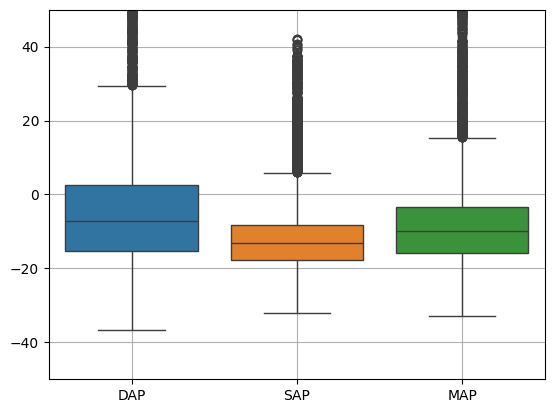

In [80]:
sns.boxplot(DF_rerr)
plt.grid()
plt.ylim([-50,50])

In [81]:
df = DF_rerr

summary = {}
for column in df.columns:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    median = df[column].median()
    iqr = q3 - q1  # Interquartilsabstand
    lower_whisker = df[column][df[column] >= (q1 - 1.5 * iqr)].min()
    upper_whisker = df[column][df[column] <= (q3 + 1.5 * iqr)].max()

    summary[column] = {
        "Q1": q1,
        "Median": median,
        "Q3": q3,
        "Lower Whisker": lower_whisker,
        "Upper Whisker": upper_whisker
    }

summary_df = pd.DataFrame(summary).T
print(summary_df)

            Q1     Median        Q3  Lower Whisker  Upper Whisker
DAP -15.303869  -7.246764  2.604066     -36.589018      29.322603
SAP -17.797889 -13.072911 -8.285720     -31.964412       5.857655
MAP -15.892439  -9.981579 -3.352641     -32.850928      15.373450
